In [15]:
# 10_player_shot_profile_analysis.ipynb
# 🎯 Player Shot Profile Analysis

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("rocket")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())



Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🔍 What You'll Explore

> **Beginner tip:** As plots appear, picture where the shots happen on the floor. Connecting numbers to court geography makes the analysis easier to remember.

Use this notebook to benchmark how players score: shot mix, assisted rates, and efficiency splits. You'll:
- confirm which seasons include player shooting tracking
- pick thresholds and shot types to analyze
- combine season rate stats with shot profiles for richer context
- visualize shot mix patterns and surface standouts in each category


In [2]:
# 📅 Discover available seasons
shooting_seasons = sorted(p.stem for p in (DATA_DIR / 'player_season_shooting_stats').glob('*.csv'))
season_files = sorted(set(shooting_seasons))
print(f"Shooting seasons available ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))



Shooting seasons available (12):
2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Set analysis parameters
Focus on one season first. If you're unsure which players to highlight, set `FOCUS_TEAM` to a school you follow and keep the rest of the defaults.

Adjust these toggle cells and re-run before executing the rest of the notebook.


In [4]:
# 🔁 Parameters
TARGET_SEASON = 2025  # choose any season listed above
MIN_TRACKED_SHOTS = 100  # minimum tracked attempts to qualify
MIN_MINUTES = 300  # require a rotation-level sample
SHOT_TYPES = ['dunks', 'layups', 'tipIns', 'twoPointJumpers', 'threePointJumpers']
SHOT_LABELS = {
    'dunks': 'Dunks',
    'layups': 'Layups',
    'tipIns': 'Tip-ins',
    'twoPointJumpers': '2P Jumpers',
    'threePointJumpers': '3P Jumpers'
}
FOCUS_TEAM = None  # e.g. 'Connecticut' to filter to one program
HIGHLIGHT_PLAYERS = ['Bennett Stirtz', 'Cooper Flagg']  # e.g. ['Player One', 'Player Two']
COMPARE_PLAYERS = ['Bennett Stirtz', 'Cooper Flagg']  # supply player names for a profile comparison table
LEADERBOARD_LIMIT = 15
SCATTER_X = 'attemptsBreakdown_threePointJumpers'
SCATTER_Y = 'trueShootingPct'

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Shot types: {SHOT_TYPES}")



Analyzing season: 2025
Shot types: ['dunks', 'layups', 'tipIns', 'twoPointJumpers', 'threePointJumpers']


## 📥 Load player shooting and season data
We merge shooting splits with traditional season stats. Check the preview to confirm the merge kept the players you expect.

Merge shooting splits with season rate stats to align usage, minutes, and efficiency context.


In [6]:
# 🗂️ Read player season shooting stats
shooting_path = DATA_DIR / 'player_season_shooting_stats' / f'{TARGET_SEASON}.csv'
shooting = pd.read_csv(shooting_path)
print(f"Loaded shooting records: {shooting.shape}")

season_path = DATA_DIR / 'player_season_stats' / f'{TARGET_SEASON}.csv'
player_rates = pd.read_csv(season_path)
print(f"Loaded rate records: {player_rates.shape}")

player_rates = player_rates.rename(columns={'athleteId': 'athleteId', 'name': 'player_name'})
merged = shooting.merge(
    player_rates,
    left_on=['athleteId', 'teamId', 'season'],
    right_on=['athleteId', 'teamId', 'season'],
    how='left',
    suffixes=('', '_season')
)

merged = merged.rename(columns={'athleteName': 'player_name_shooting'})
merged['player_name'] = merged['player_name'].fillna(merged['player_name_shooting'])

if FOCUS_TEAM:
    merged = merged.loc[merged['team'] == FOCUS_TEAM].copy()

merged = merged.dropna(subset=['player_name'])
print(f"Players after merge: {merged.shape[0]}")

merged = merged.loc[merged['trackedShots'] >= MIN_TRACKED_SHOTS].copy()
merged = merged.loc[merged['minutes'] >= MIN_MINUTES].copy()

if merged.empty:
    raise ValueError('No players meet the thresholds. Relax MIN_TRACKED_SHOTS or MIN_MINUTES.')

print(f"Players after filters: {merged.shape[0]}")
display(merged[['player_name', 'team', 'conference', 'trackedShots', 'minutes', 'effectiveFieldGoalPct']].head())



Loaded shooting records: (4972, 36)
Loaded rate records: (5144, 46)
Players after merge: 4972
Players after filters: 2595


,player_name,team,conference,trackedShots,minutes,effectiveFieldGoalPct
0,Leonardo Bettiol,Abilene Christian,WAC,302,828.00,52.60
1,Nasir DeGruy,Abilene Christian,WAC,124,579.00,38.20
2,Quion Williams,Abilene Christian,WAC,321,888.00,49.20
4,Hunter Jack Madden,Abilene Christian,WAC,245,883.00,44.60
5,Bradyn Hubbard,Abilene Christian,WAC,226,735.00,53.80


## 🧮 Derive shot profile metrics
Percentages are easier to compare than raw attempts. Notice how we convert assisted percentages and shot mixes into readable columns.

Compute shot mix shares, makes/attempts per 40 minutes, and assisted rates for each shot type.


In [7]:
# 🧮 Build shot profile frame
profile = merged.copy()
profile['minutes_per_game'] = profile['minutes'] / profile['games'].replace({0: np.nan})
profile['per40_factor'] = np.where(profile['minutes'] > 0, 40 / profile['minutes'], np.nan)

for shot in SHOT_TYPES:
    attempts_col = f'{shot}_attempted'
    made_col = f'{shot}_made'
    pct_col = f'{shot}_pct'
    share_col = f'attemptsBreakdown_{shot}'
    assisted_col = f'{shot}_assistedPct'

    if share_col in profile.columns:
        profile[f'{shot}_share_pct'] = profile[share_col]
    if pct_col in profile.columns:
        profile[f'{shot}_fg_pct'] = profile[pct_col]
    if assisted_col in profile.columns:
        profile[f'{shot}_assisted_pct'] = profile[assisted_col]
    if attempts_col in profile.columns:
        profile[f'{shot}_att_per40'] = profile[attempts_col] * profile['per40_factor']
    if made_col in profile.columns:
        profile[f'{shot}_made_per40'] = profile[made_col] * profile['per40_factor']

profile = profile.assign(
    three_point_rate=profile.get('attemptsBreakdown_threePointJumpers', np.nan),
    rim_rate=profile.get('attemptsBreakdown_layups', np.nan) + profile.get('attemptsBreakdown_dunks', 0),
    mid_range_rate=profile.get('attemptsBreakdown_twoPointJumpers', np.nan)
)

profile_columns = [
    'player_name', 'team', 'conference', 'position', 'games', 'minutes', 'minutes_per_game',
    'usage', 'trueShootingPct', 'effectiveFieldGoalPct', 'offensiveRating',
    'threePointJumpers_pct', 'threePointJumpers_assistedPct'
]

for shot in SHOT_TYPES:
    profile_columns.extend([
        f'{shot}_share_pct',
        f'{shot}_fg_pct',
        f'{shot}_assisted_pct',
        f'{shot}_att_per40'
    ])

profile = profile[[col for col in profile_columns if col in profile.columns]].copy()

print(f"Profile columns: {len(profile.columns)}")
display(profile.head())



Profile columns: 32


,player_name,team,conference,position,games,minutes,minutes_per_game,usage,trueShootingPct,effectiveFieldGoalPct,...,tipIns_fg_pct,tipIns_att_per40,twoPointJumpers_share_pct,twoPointJumpers_fg_pct,twoPointJumpers_assisted_pct,twoPointJumpers_att_per40,threePointJumpers_share_pct,threePointJumpers_fg_pct,threePointJumpers_assisted_pct,threePointJumpers_att_per40
0,Leonardo Bettiol,Abilene Christian,WAC,F,32.00,828.00,25.88,26.00,0.57,52.60,...,80.00,0.24,38.10,51.30,35.60,5.56,3.00,11.10,100.00,0.43
1,Nasir DeGruy,Abilene Christian,WAC,G,32.00,579.00,18.09,16.30,0.42,38.20,...,0.00,0.00,34.70,32.60,21.40,2.97,23.40,17.20,100.00,2.00
2,Quion Williams,Abilene Christian,WAC,G,30.00,888.00,29.60,26.20,0.53,49.20,...,83.30,0.27,37.40,37.50,17.80,5.41,16.80,33.30,88.90,2.43
4,Hunter Jack Madden,Abilene Christian,WAC,G,32.00,883.00,27.59,19.50,0.51,44.60,...,50.00,0.09,16.70,36.60,6.70,1.86,68.60,31.00,78.80,7.61
5,Bradyn Hubbard,Abilene Christian,WAC,F,31.00,735.00,23.71,21.40,0.59,53.80,...,62.50,0.44,46.50,45.70,33.30,5.71,20.40,43.50,90.00,2.50


## 📊 Shot mix overview
This summary shows which shot types dominate the league. Compare guards and forwards to understand stylistic differences.

View the average shot mix and assisted rates across the filtered player pool.


In [10]:
# 📊 Aggregated shot mix
agg_rows = []
for shot in SHOT_TYPES:
    share_col = f'{shot}_share_pct'
    fg_col = f'{shot}_fg_pct'
    ast_col = f'{shot}_assisted_pct'
    att_col = f'{shot}_att_per40'

    if share_col not in profile.columns:
        continue

    agg_rows.append({
        'shot_type': shot,
        'shot_label': SHOT_LABELS.get(shot, shot.title()),
        'avg_share_pct': profile[share_col].mean(),
        'avg_fg_pct': profile[fg_col].mean() if fg_col in profile.columns else np.nan,
        'avg_assisted_pct': profile[ast_col].mean() if ast_col in profile.columns else np.nan,
        'avg_att_per40': profile[att_col].mean() if att_col in profile.columns else np.nan
    })

shot_mix_summary = pd.DataFrame(agg_rows)
shot_mix_summary = shot_mix_summary.sort_values('avg_share_pct', ascending=False)
display(shot_mix_summary.fillna(0).round(2))



,shot_type,shot_label,avg_share_pct,avg_fg_pct,avg_assisted_pct,avg_att_per40
4,threePointJumpers,3P Jumpers,39.53,31.08,78.87,4.66
1,layups,Layups,31.23,54.40,40.44,3.61
3,twoPointJumpers,2P Jumpers,24.08,40.84,25.13,2.88
0,dunks,Dunks,3.78,63.00,47.57,0.40
2,tipIns,Tip-ins,1.39,46.10,0.00,0.15


## 🥇 Shot mix leaderboards
Leaderboards surface specialists—elite rim finishers, three-point shooters, or mid-range players. Use them to spot unique player types.

Identify players who lean hardest into each shot type. Modify the limit or shot list as needed.


In [11]:
# 🥇 Shot share leaders
for shot in SHOT_TYPES:
    share_col = f'{shot}_share_pct'
    if share_col not in profile.columns:
        print(f"⚠️ Skipping {shot}: share column missing")
        continue
    label = SHOT_LABELS.get(shot, shot)
    leaderboard = (
        profile[['player_name', 'team', 'conference', 'position', 'minutes_per_game', share_col]]
        .dropna(subset=[share_col])
        .sort_values(share_col, ascending=False)
        .head(LEADERBOARD_LIMIT)
        .assign(metric=f"{label} share (%)")
    )
    leaderboard[share_col] = leaderboard[share_col].round(1)
    display(leaderboard[['metric', 'player_name', 'team', 'conference', 'position', 'minutes_per_game', share_col]])



,metric,player_name,team,conference,position,minutes_per_game,dunks_share_pct
63,Dunks share (%),Clifford Omoruyi,Alabama,SEC,C,19.19,55.20
2060,Dunks share (%),James Scott,Louisville,ACC,F,23.60,54.90
231,Dunks share (%),Dylan Cardwell,Auburn,SEC,C,20.32,51.70
4929,Dunks share (%),Malcolm Wilson,Queens University,ASUN,F,22.26,48.70
700,Dunks share (%),Aziz Bandaogo,Cincinnati,Big 12,F,25.66,44.80
988,Dunks share (%),Khaman Maluach,Duke,ACC,C,21.26,40.70
1806,Dunks share (%),Flory Bidunga,Kansas,Big 12,F,16.32,39.30
1281,Dunks share (%),Cooper Bowser,Furman,SoCon,F,25.66,38.00
140,Dunks share (%),Shawn Phillips Jr.,Arizona State,Big 12,C,17.90,37.80
2893,Dunks share (%),Matthew Nicholson,Northwestern,Big Ten,C,24.52,37.80


,metric,player_name,team,conference,position,minutes_per_game,layups_share_pct
4810,Layups share (%),Chase Lowe,William & Mary,CAA,G,20.86,88.80
3969,Layups share (%),Josh Ogundele,Tennessee State,OVC,F,14.73,82.40
531,Layups share (%),Mahmoud Fofana,Cal State Northridge,Big West,F,26.15,82.00
750,Layups share (%),Jeff Woodward,Colgate,Patriot,F,27.79,79.80
3057,Layups share (%),Parsa Fallah,Oregon State,WCC,F,24.77,78.70
244,Layups share (%),Sai Witt,Austin Peay,ASUN,F,21.91,76.30
275,Layups share (%),Payton Sparks,Ball State,MAC,C,23.77,74.80
2565,Layups share (%),Aidan Kehoe,Navy,Patriot,C,29.24,74.50
2117,Layups share (%),Keelan Steele,Maine,Am. East,F,14.50,74.30
4159,Layups share (%),Ian Smikle,Tulsa,American,F,20.48,74.00


,metric,player_name,team,conference,position,minutes_per_game,tipIns_share_pct
261,Tip-ins share (%),Keba Keita,BYU,Big 12,C,20.97,19.60
3989,Tip-ins share (%),Felix Okpara,Tennessee,SEC,F,25.79,17.10
4917,Tip-ins share (%),Gabe Dynes,Youngstown State,Horizon,C,21.79,15.50
4795,Tip-ins share (%),Quincy Ballard,Wichita State,American,C,27.44,14.40
2247,Tip-ins share (%),Moussa Cisse,Memphis,American,C,18.26,13.80
3995,Tip-ins share (%),Cade Phillips,Tennessee,SEC,F,14.89,13.70
4727,Tip-ins share (%),Tamaury Releford,West Georgia,ASUN,C,15.67,13.50
4009,Tip-ins share (%),Henry Coleman III,Texas A&M,SEC,F,21.68,13.50
397,Tip-ins share (%),Jamai Felt,Bowling Green,MAC,F,20.23,13.10
2960,Tip-ins share (%),Sam Godwin,Oklahoma,SEC,F,19.10,13.00


,metric,player_name,team,conference,position,minutes_per_game,twoPointJumpers_share_pct
1074,2P Jumpers share (%),Devontae Blanton,Eastern Kentucky,ASUN,F,34.53,68.70
953,2P Jumpers share (%),Orlando Lovejoy,Detroit Mercy,Horizon,G,35.03,66.00
1224,2P Jumpers share (%),Vianney Salatchoum,Florida International,CUSA,C,23.47,65.80
4045,2P Jumpers share (%),Kenny Hunter,Texas Southern,SWAC,F,23.30,65.60
1558,2P Jumpers share (%),J'Wan Roberts,Houston,Big 12,F,30.32,64.50
1889,2P Jumpers share (%),Mac Etienne,La Salle,A-10,F,18.55,63.10
2505,2P Jumpers share (%),Will Thomas,Morgan State,MEAC,F,27.16,62.20
508,2P Jumpers share (%),Jemel Jones,Cal State Bakersfield,Big West,G,26.85,60.50
1787,2P Jumpers share (%),Melvyn Ebonkoli,Kansas City,Summit,C,25.88,60.40
962,2P Jumpers share (%),Grant Gondrezick II,Detroit Mercy,Horizon,G,23.00,59.80


,metric,player_name,team,conference,position,minutes_per_game,threePointJumpers_share_pct
3233,3P Jumpers share (%),Maximus Nelson,Purdue Fort Wayne,Horizon,F,23.12,94.10
3307,3P Jumpers share (%),Jason Roche,Richmond,A-10,G,22.71,93.10
2927,3P Jumpers share (%),Malcolm Christie,Oakland,Horizon,G,20.06,92.90
3983,3P Jumpers share (%),Matthew Sells,Tennessee Tech,OVC,G,19.19,92.70
35,3P Jumpers share (%),Bowen Hardman,Akron,MAC,G,15.37,92.10
4012,3P Jumpers share (%),CJ Wilcher,Texas A&M,SEC,G,10.38,91.90
2825,3P Jumpers share (%),Zach Bloch,Northern Colorado,Big Sky,G,25.91,89.80
84,3P Jumpers share (%),Tyler Mack,Alabama State,SWAC,G,13.71,89.80
857,3P Jumpers share (%),Cade Haskins,Dartmouth,Ivy,F,25.19,89.70
3199,3P Jumpers share (%),Blake Peters,Princeton,Ivy,G,29.50,89.50


## 📈 Shot mix visualization
Charts translate the tables into shapes. Look for clusters: do high-volume dunkers also score efficiently?

Plot each player's distribution of shot types to spot specialists and balanced scorers.


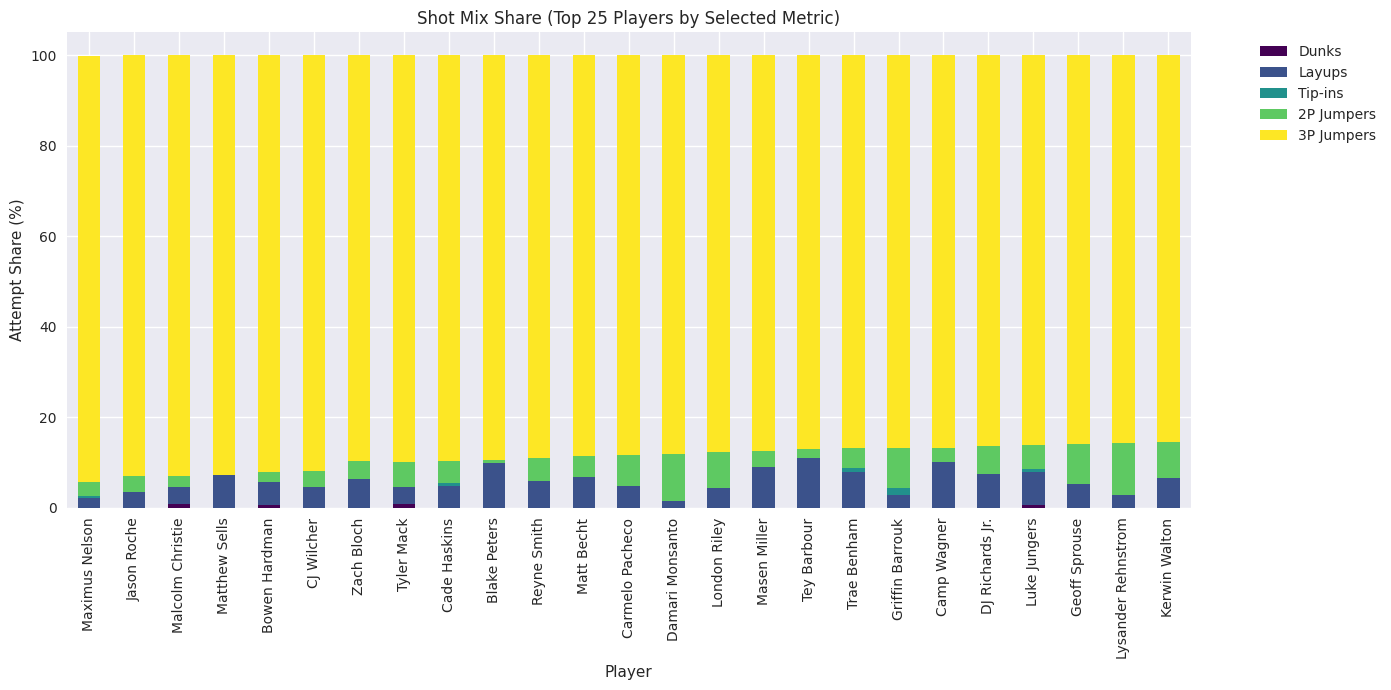

In [21]:
# 📈 Stacked bar plot per player
plot_cols = [f'{shot}_share_pct' for shot in SHOT_TYPES if f'{shot}_share_pct' in profile.columns]
plot_data = profile[['player_name', 'team'] + plot_cols].copy()
plot_data = plot_data.sort_values(plot_cols[-1] if plot_cols else 'player_name', ascending=False)
plot_data = plot_data.head(25)  # keep chart readable

plot_data = plot_data.set_index('player_name')
stack_df = plot_data[plot_cols]

stack_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Shot Mix Share (Top 25 Players by Selected Metric)')
plt.ylabel('Attempt Share (%)')
plt.xlabel('Player')
plt.legend([SHOT_LABELS.get(col.replace('_share_pct', ''), col) for col in plot_cols], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## 📉 Usage vs shooting profile
This scatter plot helps explain role fit. Players far from the pack may be ideal for specific offensive systems.

Check how shot mix correlates with efficiency or usage. Update the scatter axes via parameters.


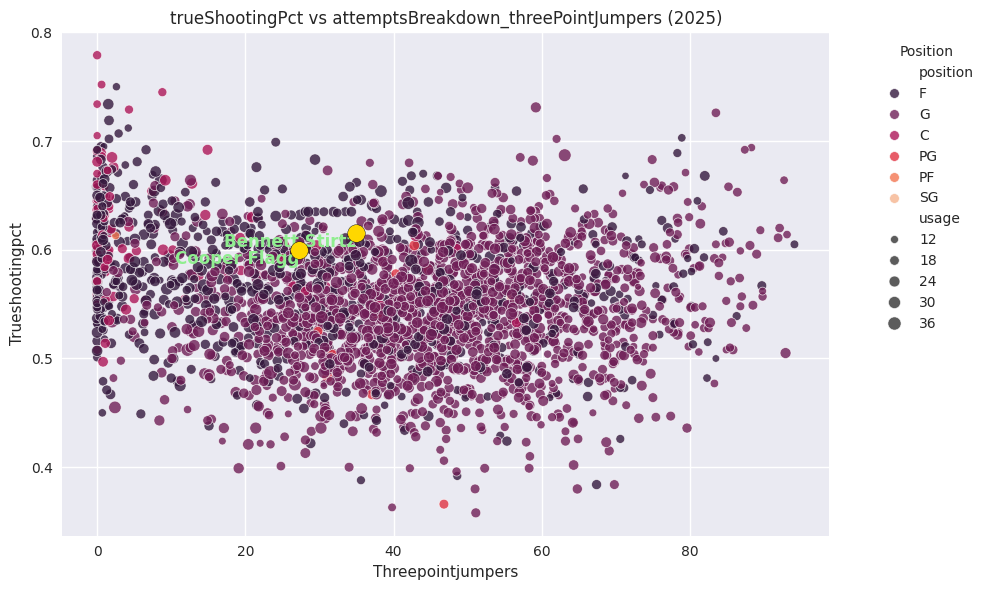

In [45]:
# 📉 Scatter plot
if SCATTER_X not in merged.columns:
    raise KeyError(f"Scatter X column {SCATTER_X} missing. Update SCATTER_X parameter.")
if SCATTER_Y not in merged.columns:
    raise KeyError(f"Scatter Y column {SCATTER_Y} missing. Update SCATTER_Y parameter.")

scatter_df = merged.dropna(subset=[SCATTER_X, SCATTER_Y]).copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scatter_df,
    x=SCATTER_X,
    y=SCATTER_Y,
    hue='position',
    size='usage',
    palette='rocket',
    alpha=0.8
)
plt.title(f"{SCATTER_Y} vs {SCATTER_X} ({TARGET_SEASON})")
plt.xlabel(SCATTER_X.replace('attemptsBreakdown_', '').replace('_', ' ').title())
plt.ylabel(SCATTER_Y.replace('_', ' ').title())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Position')

if HIGHLIGHT_PLAYERS:
    highlights = scatter_df.loc[scatter_df['player_name'].isin(HIGHLIGHT_PLAYERS)]
    for _, row in highlights.iterrows():
        plt.scatter(row[SCATTER_X], row[SCATTER_Y], color='gold', edgecolor='black', s=160, zorder=5)
        plt.text(row[SCATTER_X], row[SCATTER_Y], row['player_name'], ha='right', va='top', fontsize=12, fontweight='extra bold', color='lightgreen')

plt.tight_layout()
plt.show()



## 📋 Compare selected players
Use the side-by-side view to compare two prospects. Highlight the columns that stand out and think about how they complement each other on the floor.

Display a head-to-head shot profile table for the players you care about most.


In [46]:
# 📋 Comparison table
if COMPARE_PLAYERS:
    compare_df = profile.loc[profile['player_name'].isin(COMPARE_PLAYERS)].copy()
    if compare_df.empty:
        print('⚠️ No players matched COMPARE_PLAYERS; double-check spelling.')
    else:
        comparison_cols = [
            'player_name', 'team', 'conference', 'position', 'minutes_per_game', 'usage', 'trueShootingPct'
        ]
        for shot in SHOT_TYPES:
            comparison_cols.extend([
                f'{shot}_share_pct',
                f'{shot}_fg_pct',
                f'{shot}_assisted_pct'
            ])
        keep_cols = [col for col in comparison_cols if col in compare_df.columns]
        display(compare_df[keep_cols].round(2))
else:
    print('Set COMPARE_PLAYERS to see a detailed comparison table.')



,player_name,team,conference,position,minutes_per_game,usage,trueShootingPct,dunks_share_pct,dunks_fg_pct,dunks_assisted_pct,...,layups_fg_pct,layups_assisted_pct,tipIns_share_pct,tipIns_fg_pct,twoPointJumpers_share_pct,twoPointJumpers_fg_pct,twoPointJumpers_assisted_pct,threePointJumpers_share_pct,threePointJumpers_fg_pct,threePointJumpers_assisted_pct
969,Bennett Stirtz,Drake,MVC,G,39.40,26.80,0.62,2.10,100.00,33.30,...,67.50,22.20,0.20,100.00,34.20,38.90,7.10,34.90,40.10,37.30
989,Cooper Flagg,Duke,ACC,G,30.65,30.80,0.60,6.70,93.90,45.20,...,54.10,25.90,1.60,50.00,32.70,40.10,32.30,27.30,38.50,82.70


## ✅ Next steps
Carry your notes into scouting meetings. Knowing where players take shots makes it easier to plan matchups and drill priorities.

- Blend game-level shot charts to analyze home/away or month-by-month trends.
- Join synergy-style defensive metrics to compare against opponent shot profiles.
- Export `shot_mix_summary` and player profiles to CSV for dashboards or scouting packets.
